In [1]:
# codefolding: https://github.com/ipython-contrib/jupyter_contrib_nbextensions
from functools import partial
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})
import pandas as pd
_df = pd.DataFrame
show = lambda dd: display(_df(dd))
import seaborn
from scipy.sparse import csgraph, csr_matrix
from sklearn.utils import graph_shortest_path

from hlt.transform import (
  yx2ngbrs, dist_mtn
  )
from hlt.util import (
  flatmap, mapl, maps_itr, maps_func, memo, # DATA
  asrt, lvl2lgr, log, logitr, logaz, timit, # DEBUG
  )
timit = partial(timit, lvl='warn')

In [2]:
def make_map(dim=8, _show=False, min_max=(0,1000)):
  _map = np.random.uniform(*min_max, size=(dim,dim)).astype(int)
  if _show: show(_map)
  return _map

def translate_dims(dim): # translate coordinates: 1D <> 2D
  def two2one(y, x): # 2d -> 1d
    return y*dim+x
  def one2two(i): # 1d -> 2d
    return (i//dim, i%dim)
  return two2one, one2two

@timit()
def map2dists(_map, _show=False):
  dim = len(_map) # _map: n x n
  two2one, one2two = translate_dims(dim)
  @timit()
  def init(): return np.full(shape=[dim*dim]*2, fill_value=np.inf)#.astype(int) # dists: n^2 x n^2
  @timit()
  def setup(dists):
    for (y,x), hlt in np.ndenumerate(_map):
      i1d = two2one(y,x)
      dists[i1d, i1d] = 0
      for yx_ngbr in yx2ngbrs(y, x, dim):
        dists[i1d, two2one(*yx_ngbr)] = _map[y, x]
    return dists
  dists = setup(init())
  if _show: show(dists)
  return dists

@memo()
def _yx2ngbrs(y,x, dim):
  yxs_naive = [(y,x+1),(y+1,x),(y,x-1),(y-1,x)]
  return [(yd%dim, xd%dim) for yd,xd in yxs_naive]

def hmap(mat, lmh=(None,None,None),colors='PiYG_r',**kwargs):
  vmin,center,vmax = lmh
  kwargs['vmin'] = vmin
  kwargs['center'] = center
  kwargs['vmax'] = vmax
  df = pd.DataFrame(mat).replace([np.inf,-np.inf], np.nan) # mask inf vals
  cmap = plt.get_cmap(colors)
  cmap.set_bad(color='black', alpha=np.nan)
#   cmap.set_over(color='black', alpha=vmax)
#   cmap.set_under(color='k', alpha=vmin)
  with seaborn.axes_style('darkgrid'):
    heatmap = seaborn.heatmap(df,cmap=cmap,annot=True,fmt='g', **kwargs)
  return heatmap

# _map = make_map(4)
# hmap(_map,lmh=(0,0,1000),colors='PiYG')

In [ ]:
""" Classic no-wrap path-cheapest A->Z: T(N)
  8x8 ~2ms
  32x32 ~15ms
  64x64 ~70ms
  """
@timit(lvl='warn')
def combo(_map):
  dim = len(_map)
  @memo()
  def cost2(y,x): # 1) no-wrap TODO -> 2) torus
    val = _map[y,x]
    if y==0: return sum(_map[0,:x]) + val
    elif x==0: return sum(_map[:y, 0]) + val
    else: return min(cost2(y,x-1), cost2(y-1,x)) + val
  # @memo(lvl='warn')
  @memo()
  def ptr2(y,x):
    if y==x==0: return 'O'
    elif y==0:  return '<'
    elif x==0: return '^'
    else: return '<' if cost2(y,x-1)<=cost2(y-1,x) else '^'
  return [[
  (_map[y,x], 
   ptr2(y,x), 
   cost2(y,x))
  for x in range(dim)] 
  for y in range(dim)]
@timit(lvl='warn')
def get_all_combos(_map):
  pass
_map = make_map(64,False)
show(combo(_map))
# get_all_combos(_map)

In [ ]:
""" Goal: pairwise path-cheapest cost & ptrs -> Floyd-Warshall
  Naive: T(N^3) -> 8x8 ~550ms :'(
  Hlt3: ? T(N*k*(N-k)) ~ T(N^2)
    1) undirected: i,j==j,i => 2/
    2) only ships_mine -> not ships_mine: => N/
    3) matrix-ngbr context?
  """
@timit(lvl='warn')
def floyd_warshall(_map):
  dim = len(_map)
  YXS = list(product( *[range(dim)]*2 ))
  COSTS = np.full(shape=[dim]*4, fill_value=float('inf')) # (i, j) -> cost$i->j
  def cost(yx_i, yx_j, yx_k=None): # cheapest known cost $ i->j (opt via k)
    if not yx_k: return COSTS[(*yx_i, *yx_j)] # cost$i->j
    else: return cost(yx_i,yx_k) + cost(yx_k,yx_j) # cost$i->k->j
  def set_cost(yx_i,yx_j, _cost): COSTS[(*yx_i, *yx_j)] = _cost # cost#i->j <- _cost
  def weight(yx_i, yx_ngbr): return _map[(*yx_i,)] # Halite3: ngbr$i,j => cost$i->j <- val$i
  NEXTS = np.full([dim]*4, None) # (i, j) -> k: st cost$i->k->j == min$cost$i->j
  def next_(yx_i, yx_j): return NEXTS[(*yx_i, *yx_j)]
  def set_next(yx_i,yx_j, _next): NEXTS[(*yx_i, *yx_j)] = _next
  # @memo() # maybe useful when queried in game
  def path(yx_i, yx_j):
    if not next_(yx_i, yx_j): return [] # base: next$i==j -> None
    else: nexts = [(yx_i, weight(yx_i,yx_j))] + path(next_(yx_i,yx_j), yx_j) # ndct: recursive
    return nexts
  ## init: base & ndct cases
  for yx in YXS:
    set_cost(yx, yx, 0) # v->v: 0
    for yx_ngbr in _yx2ngbrs(*yx, dim): # v->ngbr: val(v) <- Halite3
      set_cost(yx, yx_ngbr, weight(yx, yx_ngbr))
      set_next(yx, yx_ngbr, yx_ngbr)
  ## update: cost(all vertex-pairs i & j) via v_k
  for yx_k in YXS:
    for yx_i in YXS: # Hlt3: just ships << whole map
      if cost(yx_i,yx_k) == np.inf: continue
      for yx_j in YXS: # Hlt3: not ships_mine
        if cost(yx_i,yx_j) > cost(yx_i,yx_j,yx_k): # update cost & next (i,j) & (j,i) !
          set_cost(yx_i,yx_j, cost(yx_i,yx_j,yx_k))
          set_next(yx_i,yx_j, next_(yx_i,yx_k))
  return cost, path # pairwise cheapest-path's 1) cost 2) actual
floyd_warshall(make_map(8,False))

In [ ]:
""" use built-in FW for better perf -> preproc once start of game
  each turn only update cells that changed
  8x  3ms
  12x 5ms
  16x 20ms
  20x 70ms
  24x 150ms
  32x 800ms <- viable turnly limit
  48x 8500ms!!!
  """
@timit()
def sp_fw(dists, _show=False):
  costs, nexts = csgraph.floyd_warshall(dists, directed=False, return_predecessors=True)
  if _show:
    show(costs)
    show(nexts)
  return costs, nexts
@timit()
def sk_fw(dists, _show=False):
  costs = graph_shortest_path.graph_shortest_path(dists, directed=False, method='FW')
  return costs
_map = make_map(32,False)
dists = map2dists(_map,False)
costs, nexts = sp_fw(dists,False)
costs = sk_fw(dists,False)

In [ ]:
""" Dijkstra/A* search foreach (srcs -> ngbrs + tgts) where S+T << N
  T(S*T * NlogN) ~ T(N^2 logN)
  16x 24ms
  20x 70ms
  32x 430ms
  48x 2400ms
  64x 8000ms
  """
@timit()
def path_cheapest(dists, _show=False):
  costs, preds = csgraph.shortest_path(dists, method='D', directed=False, return_predecessors=True)
  if _show:
    show(costs)
    show(preds)
#   return costs, preds  
path_cheapest(map2dists(make_map(4,True),True), True)

In [63]:
from math import ceil, floor
from queue import PriorityQueue
"""BestFirstSearch
  1 seek value: scan perim
  2 cheapest return: A* heuristic guide: src->tgt
  """
def pq(item_init=None, lvl='debug'):
  logf = lvl2lgr(lvl)
  def pq_put(item):
    _pq.put(item)
    logf('+ %s [%d]', item, _pq.qsize())
  def pq_get():
    item = _pq.get()
    logf('- %s [%d]', item, _pq.qsize())
    return item
  empty = lambda: _pq.empty()
#   stats = lambda: logf('# puts: %d; # gets: %d', n_puts, n_gets)
  _pq = PriorityQueue()
  if item_init: pq_put(item_init)
  return pq_put, pq_get, empty#, stats
@timit() # TODO vectorize
def decay_map(_map, src, r_decay=1.):
  f = lambda yx: _map[yx] * r_decay**dist_mtn(src, yx, len(_map))
#   return np.vectorize(f)(_map)
  _decay_map = _map.copy()
  for yx, _ in np.ndenumerate(_decay_map):
    _decay_map[yx] = f(yx)
  return _decay_map
## 1 scan for best-value
R_COST_MOVE=.1
@timit()
def scan(_map, src, perim=2, r_decay=1., lvl='debug'):
  dim = len(_map)
  cost_init = np.inf
  cost_map = np.full((dim,dim),fill_value=cost_init)
  seen = lambda yx: cost_map[yx]!=cost_init
  put, get, empty = pq(item_init=(0,0,src,src), lvl=lvl) # (cost,dist,yx_curr,yx_prev)
  def clj_backtrack(dim): # back-propagate outer values -> immediate moves
    curr2prev = {}
    backtrack_map = np.full((dim,dim),fill_value=0)
    def back_ptr(yx_curr, yx_prev): curr2prev[yx_curr] = yx_prev
    def backtrack(yx_curr, yx_prev):
      if yx_curr==src: return
      backtrack_map[yx_prev] = max(val_map[yx_curr], val_map[yx_prev])
      if yx_prev!=src: backtrack(yx_prev, curr2prev[yx_prev])
    return back_ptr, backtrack, backtrack_map
  back_ptr, backtrack, backtrack_map = clj_backtrack(dim)
  _decay_map = decay_map(_map, src, r_decay) # OPT
  val_map = _decay_map.copy() # ~= _decay_map - cost_map
  while not empty():
    cost,dist,yx_curr,yx_prev = get()
    if cost < cost_map[yx_curr]: # first visit also cheapest -> update maps
      cost_map[yx_curr] = cost
      val_map[yx_curr] -= cost
      backtrack(yx_curr, yx_prev)
      if dist<perim: # expand suitable ngbrs
        for yx_ngbr in [yx for yx in yx2ngbrs(*yx_curr, dim) if not seen(yx)]:
          back_ptr(yx_ngbr, yx_curr)
          cost_ngbr = floor(cost + _decay_map[yx_curr]*R_COST_MOVE)
          put( (cost_ngbr, dist+1, yx_ngbr, yx_curr) )
    else:
      backtrack(yx_curr, yx_prev)
#   val_map = decay_map(_map, src, r_decay) - cost_map
  return _map, _decay_map, cost_map, val_map, backtrack_map

@timit() # funcize subplot suite
def plots(min_max, _map, _decay_map, cost_map=None, val_map=None, backtrack_map=None):
  vmin,vmax = min_max
#   n = 3 if (val_map is None and backtrack_map is None) else 6
  n=6
  fig, ax = plt.subplots(n//3,3, sharey='row', figsize=(6*3,5*(n//3)))
  hmap(_map, lmh=(vmin,0,vmax), colors='PiYG', ax=ax[0,0])
  hmap(_decay_map, lmh=(vmin,0,vmax), colors='PiYG', ax=ax[0,1])
  hmap(cost_map, lmh=(vmin,0,None), colors='PiYG_r', ax=ax[0,2])
#   if not (val_map is None and backtrack_map is None):
  hmap(val_map, lmh=(None,0,vmax), colors='PiYG', ax=ax[1,0])
  hmap(_decay_map-cost_map, lmh=(None,0,vmax), colors='PiYG', ax=ax[1,1])
  hmap(backtrack_map, lmh=(None,0,vmax), colors='PiYG', ax=ax[1,2])
  plt.show()
DIM = 8
VMIN, VMAX = 0, 100
min_max = (VMIN,VMAX)
MAP = make_map(DIM,False,(VMIN,VMAX))

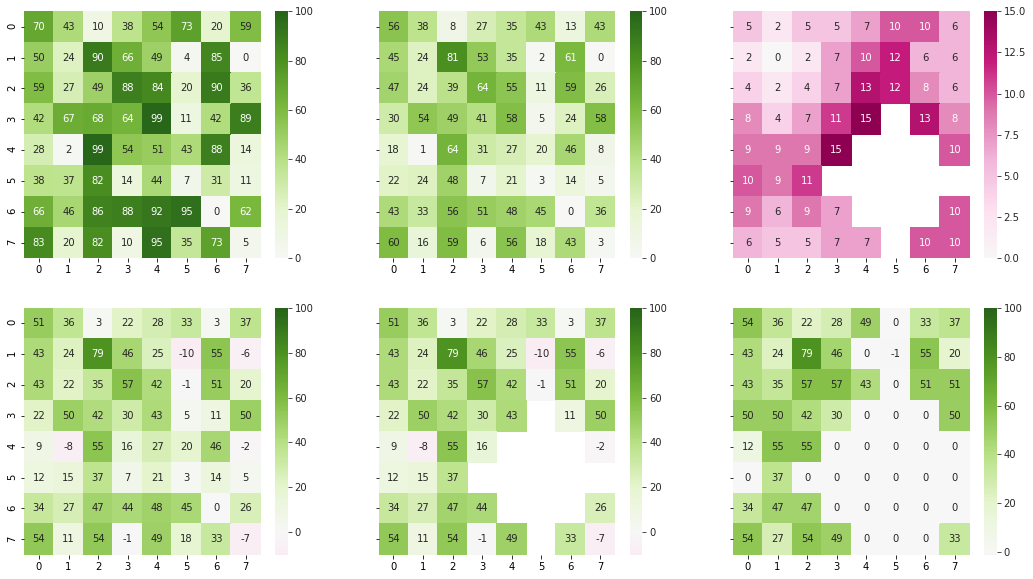

In [64]:
PERIM=5
R_DECAY = .9
# utils for debugging & visualizing BFS actions
def move(dst, _map=MAP, perim=PERIM, r_decay=R_DECAY):
  plots(min_max, *scan(_map, dst, perim=PERIM, r_decay=R_DECAY))
def pick(src, _map=MAP, perim=PERIM, r_decay=R_DECAY):
  MAP[src] *= 0.75
  plots(min_max, *scan(MAP, src, perim=PERIM, r_decay=R_DECAY))
# test 1) seek value in perim
move((1,1))

In [58]:
## 2 seek cheapest path
@timit()
def seek(_map, src, tgt, r_decay=1., lvl='debug'):
  dim = len(_map)
  cost_init = np.inf
  cost_map = np.full((dim,dim),fill_value=cost_init)
  seen = lambda yx: cost_map[yx]!=cost_init
  def g_cost(yx): return cost_map[yx] # best cost-realized: src -> yx
  def h_cost(yx0,yx1): return dist_mtn(yx0,yx1,dim) # heuristic cost-forward: yx -> tgt
#   def f_cost(yx0,yx1): return (g_cost(yx1), h_cost(yx0,yx1)) # 
  seed = 0, h_cost(src,tgt), src # g, h, yx
  put, get, empty = pq(item_init=seed, lvl=lvl)
  i = 0
  while not empty():
    i+=1
    g, h, yx_curr = get()
    if g > g_cost(yx_curr): continue
    else:
      cost_map[yx_curr] = g # update w/ better cost-realized
      if yx_curr == tgt:
        log.warning('Found target after %d iters!', i)
        break
      for yx_ngbr in yx2ngbrs(*yx_curr, dim):
        if not seen(yx_ngbr) and h_cost(yx_ngbr,tgt) < h_cost(src,tgt):
          g = floor(g_cost(yx_curr) + _map[yx_curr]*R_COST_MOVE * r_decay) # knobs...
          put( (g, h_cost(yx_ngbr,tgt),yx_ngbr) )
  val_map = decay_map(_map, src, r_decay) - cost_map
  return _map, cost_map, val_map

In [ ]:
# test 2) seek cheapest path src->tgt
plots(min_max, *seek(MAP, (1,1), (6,4)))
plots(min_max, *seek(MAP, (1,1), (6,4), r_decay=.9))